# Taper example

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

In [2]:
from zfel import sase1d_input_part

import numpy as np

import matplotlib.pyplot as plt

import scipy.io
import random
import datetime
import time


%config InlineBackend.figure_format = 'retina'

In [3]:
def taper_output(unduK):
    '''
    Input:
    unduK is an array to represent taper profile (recommend to be a shape of (200,)
    
    Output:
    z is the position array along the undulator
    power_z is the output power along undulator
    '''
    
    # Basic parameters
    Nruns=1                             # Number of runs
    npart   = 512                       # n-macro-particles per bucket 
    s_steps = 200#200#30   300                 # n-sample points along bunch length
    z_steps = unduK.shape[0]#200#30   300                 # n-sample points along undulator
    energy  = 4313.34*1E6               # electron energy [eV]
    eSpread = 0#1.0e-4                  # relative rms energy spread [ ]
    emitN   = 1.2e-6                    # normalized transverse emittance [m-rad]
    currentMax = 3900                   # peak current [Ampere]
    beta = 26                           # mean beta [meter]
    unduPeriod = 0.03                   # undulator period [meter]
    #unduK = 3.5                        # undulator parameter, K [ ]
    #unduK = np.ones(z_steps)*3.5  # tapered undulator parameter, K [ ]
    #if unduK.shape[0]!=z_steps:
    #    print('Wrong! Number of steps should always be the same as z_steps')
    unduL = 70#30                       # length of undulator [meter]
    radWavelength = 1.5e-9              # seed wavelength? [meter], used only in single-freuqency runs

    mc2 = 0.51099906E6#510.99906E-3      # Electron rest mass in eV

    gamma0  = energy/mc2                                    # central energy of the beam in unit of mc2

    radWavelength=unduPeriod*(1+unduK[0]**2/2.0)\
                        /(2*gamma0**2)                          # resonant wavelength

    dEdz = 0                            # rate of relative energy gain or taper [keV/m], optimal~130
    iopt = 'sase'                       # 'sase' or 'seeded'
    P0 = 10000*0.0                      # small seed input power [W]
    constseed = 1                       # whether we want to use constant random seed for reproducibility, 1 Yes, 0 No
    
    particle_position=np.genfromtxt('./Inputs/SASE_particle_position.csv', delimiter=',') # or None  
    
    # particle information with positions in meter and eta,\
    # if we want to load random particle positions and energy, then set None
    hist_rule='square-root'             # 'square-root' or 'sturges' or 'rice-rule' or 'self-design', number \
                                        #  of intervals to generate the histogram of eta value in a bucket
        
    

    inp_struct={'Nruns':Nruns,'npart':npart,'s_steps':s_steps,'z_steps':z_steps,'energy':energy,'eSpread':eSpread,\
                'emitN':emitN,'currentMax':currentMax,'beta':beta,'unduPeriod':unduPeriod,'unduK':unduK,'unduL':\
                    unduL,'radWavelength':radWavelength,'dEdz':dEdz,'iopt':iopt,'P0':P0,'constseed':constseed,'particle_position':particle_position,'hist_rule':hist_rule}
    
    output = sase1d_input_part.sase(inp_struct)
    
    z = output['history']['z']
    power_z = output['history']['power_z']
    
    return z,power_z

# K array

In [4]:
MY_K_ARRAY = np.ones(200)*3.5

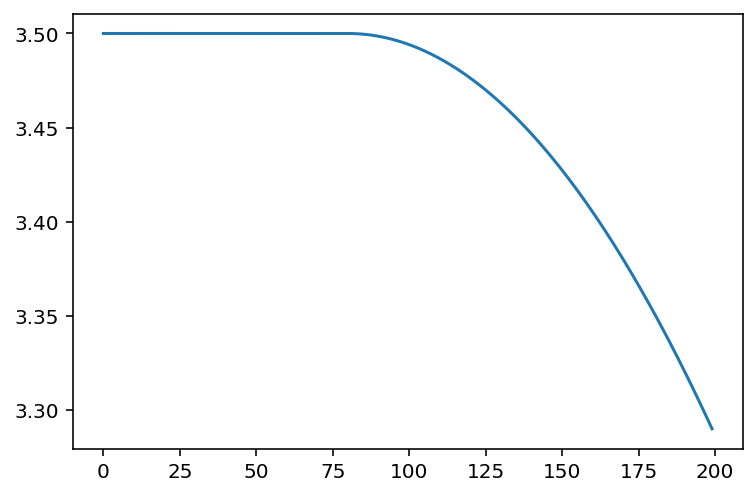

In [5]:
def k_taper(k0=3.5, a=0.5, n=200, split_ix=80):
    return np.hstack([np.ones(split_ix), (1- a*np.linspace(0, 1, n-split_ix)**2)])*k0
    
plt.plot(k_taper(a=.06))


# Run ZFEL

In [6]:
%%time
K0 = k_taper(a=0)
z, power0 =taper_output(K0)

CPU times: user 9.12 s, sys: 136 ms, total: 9.26 s
Wall time: 9.48 s


In [7]:
%%time
K1 = k_taper(a=0.06)
z, power1 =taper_output(K1)

CPU times: user 9.3 s, sys: 147 ms, total: 9.44 s
Wall time: 9.64 s


# Plot output

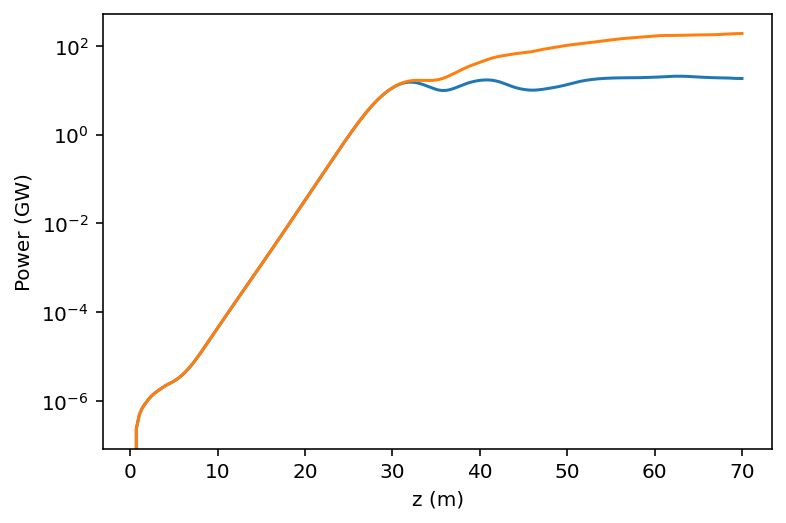

In [8]:
plt.xlabel('z (m)')
plt.ylabel('Power (GW)')
plt.yscale('log')
plt.plot(z,power0/1e9)
plt.plot(z,power1/1e9)

In [9]:
def run_taper(a):
    out = {}
    out['a'] = a
    out['k'] = k_taper(a=a)
    out['z'], out['power'] = taper_output(out['k'])
    return out

results = [run_taper(a) for a in np.linspace(0, .1, 10)] 

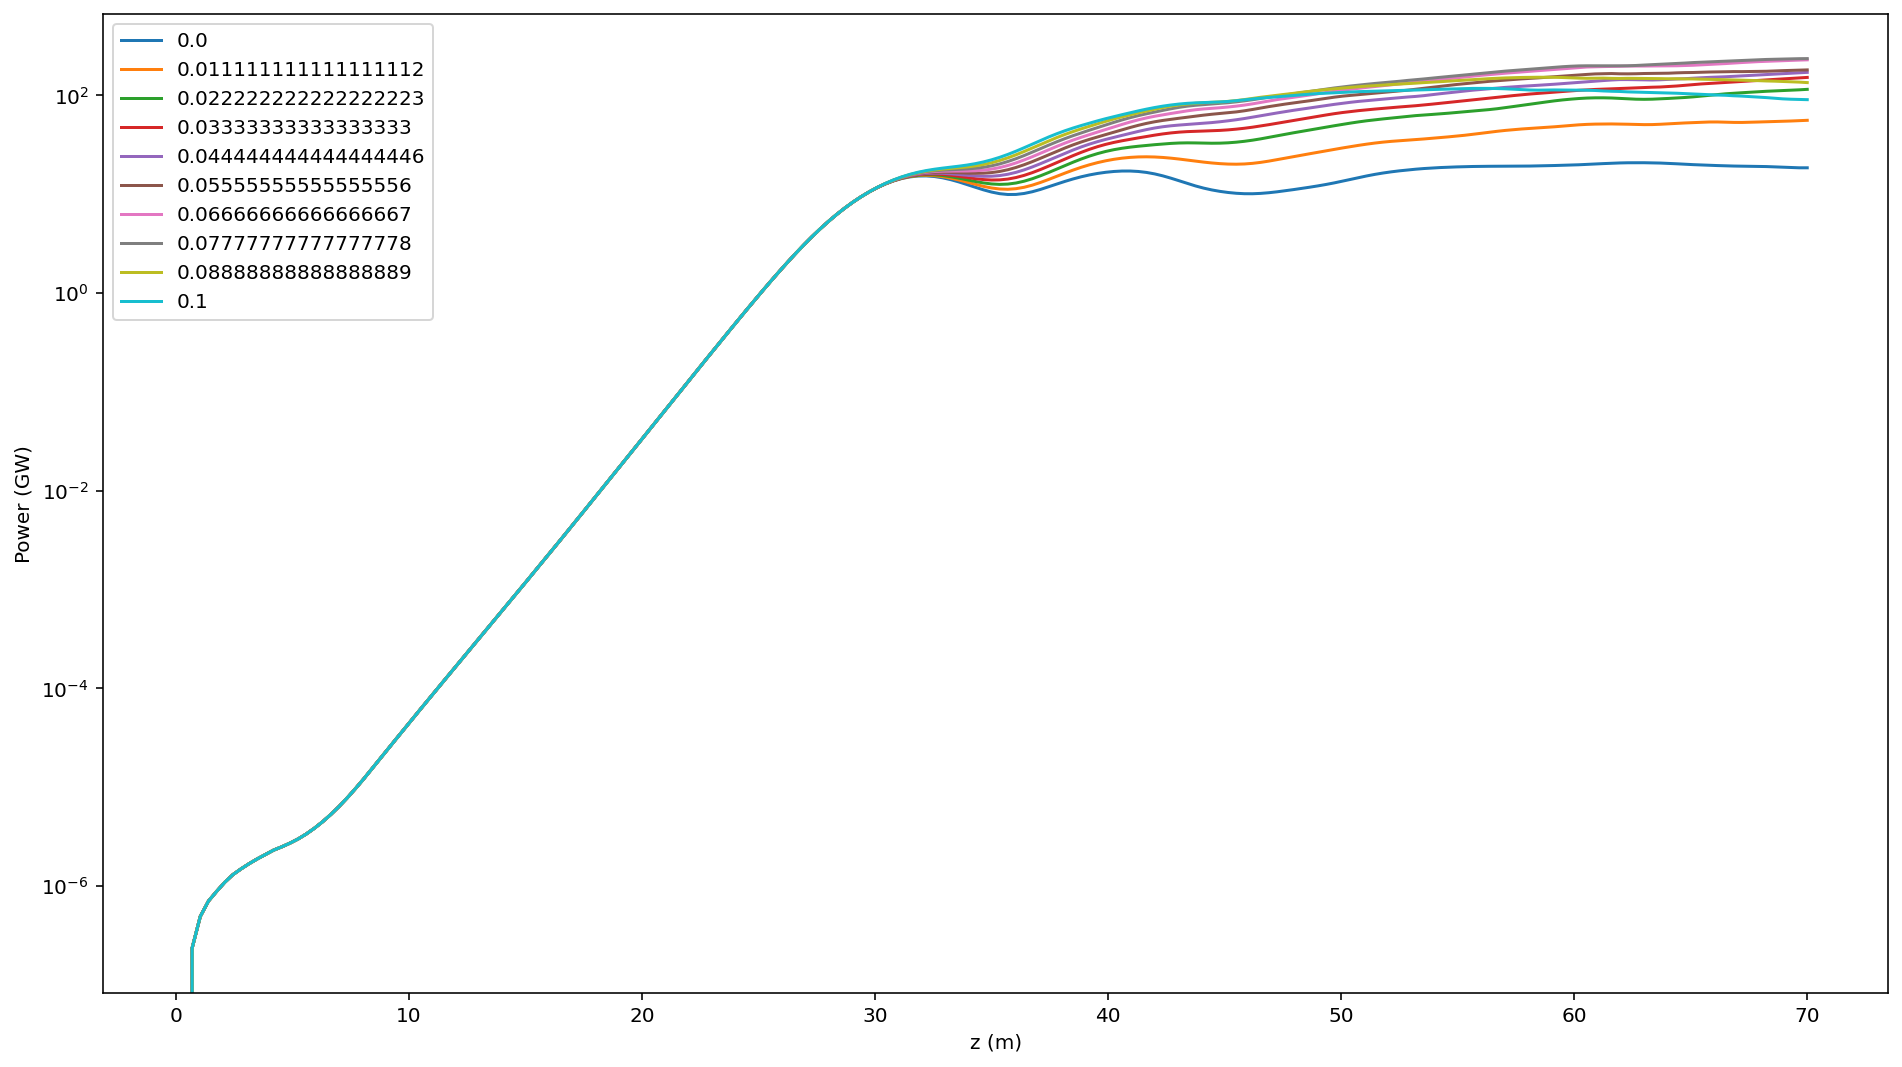

In [10]:
fig, ax = plt.subplots(figsize=(16,9))

ax.set_xlabel('z (m)')
ax.set_ylabel('Power (GW)')
for res in results:
    
    ax.plot(res['z'], res['power']/1e9, label=res['a'])

ax.set_yscale('log')
ax.legend()

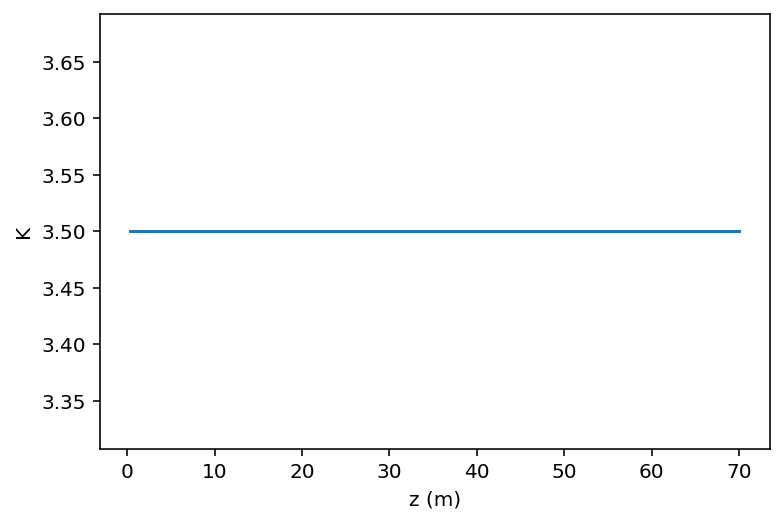

In [11]:
plt.ylabel('K')
plt.xlabel('z (m)')
plt.plot(z, MY_K_ARRAY)